# Convolutional Neural Networks

In this notebook we will be perform the task of image classification on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset using Convolutional Neural Networks based on Visual Geometry Group (VGG) network

## Importing the libraries

To implement the network we will be using [PyTorch](https://pytorch.org/) library

In [7]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Getting the dataset

We will get the CIFAR-10 dataset from the torchvision package present in pytorch, some example images from the dataset are shown below
<!-- ![CIFAR10.png](attachment:CIFAR10.png) -->
<img src="CIFAR10.png" alt="drawing" style="width:400px;"/>

In [9]:
DATA_PATH = "../data/"

# getting the training data
train = torchvision.datasets.CIFAR10(DATA_PATH, 
                         train=True, 
                         download=True, 
                         transform = transforms.ToTensor())

# getting the testing data
test = torchvision.datasets.CIFAR10(DATA_PATH, 
                        train=False, 
                        download=True, 
                        transform = transforms.ToTensor())

# class mapping from CIFAR documentation
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Normalizing the dataset

The images in PIL are downloaded with range 0 to 1 and are not normalized, for better learning of the network we will normalize the dataset.

To normalize the dataset we calculate mean and standard deviation for each channel in the training data

In [10]:
images = torch.stack([img for img, _ in train], dim=3)

# calculating mean for each channgel in training data
MEAN = images.view(3, -1).mean(dim=1)

# calculating standard deviation for each channel in training data
SD = images.view(3, -1).std(dim=1)

In [11]:
MEAN, SD

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

We will reload the datasets and apply following transforms to them:
- Converting the images to Tensor so PyTorch can handle them
- Normalizing each channel of the image

We will also split the training data to a training dataset and a validation dataset to monitor overfitting and guide training

In [12]:
# reloading the dataset with applied normalization

# getting the training data
train = torchvision.datasets.CIFAR10(DATA_PATH, 
                         train=True, 
                         download=True, 
                         transform = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(MEAN, SD)
                         ]))

# creating a validation set from training set with 90-10 split
from torch.utils.data.dataset import random_split
train_size = int(len(train) * 0.9) # 90% training data
valid_size = len(train) - train_size # 10% validation data
train, validation = random_split(train, [train_size, valid_size])

# getting the testing data
test = torchvision.datasets.CIFAR10(DATA_PATH, 
                        train=False, 
                        download=True, 
                        transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(MEAN, SD)
                        ]))

Files already downloaded and verified
Files already downloaded and verified


Creating minibatch loader for training using the **DataLoader** class

In [13]:
# Defining the batch size
BATCH_SIZE = 4

# creating dataloader object for dataset
train_loader = DataLoader(train,
                         batch_size=BATCH_SIZE,
                         shuffle=True)

validation_loader = DataLoader(validation,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

test_loader = DataLoader(test,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

## Baseline model

We will be using a VGG style architecture, we first train a model with a single VGG block and two fully connected layers

The VGG block is shown in the image below:

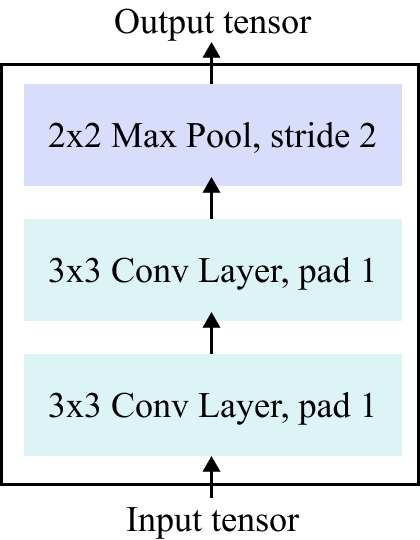

In [130]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully connected layers
        self.fc1 = nn.Linear(16*16*32, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # block 1
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        # fully connected layers
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = ConvNet()

In [131]:
# checking forward pass
net(torch.rand(1,3,32,32)).shape

torch.Size([1, 10])

### Defining the loss function

Since we are performing a multi-class classification, we will be using Cross Entropy Loss

In [132]:
loss_fn = nn.CrossEntropyLoss()

### Defining the optimizer
We will be using a stochastic gradient descent optimizer to train out model

In [134]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), 
                      lr=0.01)

## Training Model 1

In [18]:
# lists for monitoring the progress of training Model-1
m1_batch = []
m1_train_loss = []
m1_train_accuray = []
m1_val_loss = []
m1_val_accuracy = []

In [162]:
# defining the training epochs 10
N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    
    # loss calculate for an epoch
    running_loss = 0.0
    correct = 0
    seen = 0
    
    for i, data in enumerate(train_loader, 0):
        # getting the batch for training
        inputs, labels = data

        # zero the accumulated parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = net(inputs)
        
        # calculating the outputs
        _, predicted = torch.max(outputs.data, 1)
        
        # calculating the loss for batch
        loss = loss_fn(outputs, labels)
        
        # calculating the gradients by backward pass
        loss.backward()
        
        # updating the prameters based on gradient
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        seen += len(predicted)
        correct += sum(predicted == labels)
        
        if i % 500 == 499:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}, accuracy: {correct/seen:0.3f}')
            
            #storing the loss and accuracy
            m1_batch += [(epoch+1) * (i+1)]
            m1_train_loss += [running_loss / 2000]
            m1_train_accuray +=  [correct / seen]
            
            running_loss = 0.0
            correct = seen = 0
            
            # validation set loss and accuracy
            with torch.no_grad():
                val_loss = 0
                val_correct = 0
                val_seen = 0
                for inputs, labels in validation_loader:
                    outputs = net(inputs)

                    # calculating the outputs
                    _, predicted = torch.max(outputs.data, 1)

                    # calculating the loss for validation batch
                    val_loss += loss_fn(outputs, labels)
                    
                    # calculating accuracy for the validation batch
                    val_correct += sum(predicted == labels)
                    val_seen += len(labels)
                    
                m1_val_loss += [val_loss]
                m1_val_accuracy += [val_correct/val_seen]
                print(f'[{epoch + 1}, {i + 1:5d}] val loss: {val_loss/2000:0.3f}, accuracy: {val_correct/val_seen:0.3f}')

print('Finished Training')

[1,   500] loss: 0.021, accuracy: 0.971
[1,   500] val loss: 1.594, accuracy: 0.657
[1,  1000] loss: 0.018, accuracy: 0.976
[1,  1000] val loss: 1.578, accuracy: 0.660
[1,  1500] loss: 0.017, accuracy: 0.975
[1,  1500] val loss: 1.708, accuracy: 0.663
[1,  2000] loss: 0.008, accuracy: 0.990
[1,  2000] val loss: 1.722, accuracy: 0.667
[1,  2500] loss: 0.016, accuracy: 0.979
[1,  2500] val loss: 1.707, accuracy: 0.664
[1,  3000] loss: 0.021, accuracy: 0.976
[1,  3000] val loss: 1.694, accuracy: 0.660
[1,  3500] loss: 0.020, accuracy: 0.973
[1,  3500] val loss: 1.743, accuracy: 0.655
[1,  4000] loss: 0.024, accuracy: 0.974
[1,  4000] val loss: 1.661, accuracy: 0.656
[1,  4500] loss: 0.022, accuracy: 0.975
[1,  4500] val loss: 1.670, accuracy: 0.661
[1,  5000] loss: 0.015, accuracy: 0.984
[1,  5000] val loss: 1.730, accuracy: 0.665
[1,  5500] loss: 0.021, accuracy: 0.974
[1,  5500] val loss: 1.676, accuracy: 0.660
[1,  6000] loss: 0.029, accuracy: 0.965
[1,  6000] val loss: 1.694, accuracy

Text(0.5, 0, 'Epcohs')

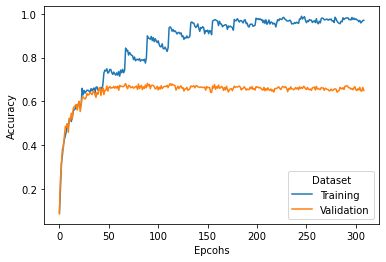

In [160]:
plt.plot(m1_train_accuray[22:], label = "Training")
plt.plot(m1_val_accuracy[22:], label = "Validation")
plt.legend(title="Dataset")
plt.ylabel("Accuracy")
plt.xlabel("Epcohs")

In [37]:
def train_model(net, n_epochs, loss_fn, optimizer):
    """
    A generic function to train the convolution neural network
    
    Parameters:
    net: <nn.Module> the PyTorch neural network model
    n_epochs: <int> number of epochs to train the model for
    loss_fn: loss function to be used for model output
    optimizer: The optimizer to update the parameters
    """
    
    # arrays to store and trach progress of the training process
    m_batch = []
    m_train_loss = []
    m_train_accuray = []
    m_val_loss = []
    m_val_accuracy = []
    
    for epoch in range(n_epochs):

        # loss calculated for an epoch
        running_loss = 0.0

        # number of correct
        correct = 0

        # number of instances seen
        seen = 0

        for i, data in enumerate(train_loader, 0):
            # getting the batch for training
            inputs, labels = data

            # zero the accumulated parameter gradients
            optimizer.zero_grad()

            # forward pass
            outputs = net(inputs)

            # calculating the outputs
            _, predicted = torch.max(outputs.data, 1)

            # calculating the loss for batch
            loss = loss_fn(outputs, labels)

            # calculating the gradients by backward pass
            loss.backward()

            # updating the prameters based on gradient
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            seen += len(predicted)
            correct += sum(predicted == labels)

            if i % 500 == 499:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}, accuracy: {correct/seen:0.3f}')

                #storing the loss and accuracy
                m_batch += [(epoch+1)*len(train) * (i+1)]
                m_train_loss += [running_loss]
                m_train_accuray +=  [correct / seen]

                running_loss = 0.0
                correct = seen = 0

                # validation set loss and accuracy
                with torch.no_grad():
                    val_loss = 0
                    val_correct = 0
                    val_seen = 0
                    for inputs, labels in validation_loader:
                        outputs = net(inputs)

                        # calculating the outputs
                        _, predicted = torch.max(outputs.data, 1)

                        # calculating the loss for validation batch
                        val_loss += loss_fn(outputs, labels)

                        # calculating accuracy for the validation batch
                        val_correct += sum(predicted == labels)
                        val_seen += len(labels)

                    m_val_loss += [val_loss]
                    m_val_accuracy += [val_correct/val_seen]
                    print(f'[{epoch + 1}, {i + 1:5d}] validation loss: {val_loss/2000:0.3f}, accuracy: {val_correct/val_seen:0.3f}')

    print('Finished Training')
    
    return {
        "batch": m_batch,
        "training loss": m_train_loss,
        "training accuracy": m_train_accuray,
        "validation loss": m_val_loss,
        "validation accuracy": m_val_accuracy
        }

### Testing dataset accuracy of Model-1

In [42]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 66 %


## Model 2

To improve the accuracy of model, we add another VGG block to previous model.

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # block 2
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding = 1)
        
        # fully connected layers
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # block 1
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        # block 2
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        
        # fully connected layers
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


net2 = ConvNet2()

## Training Model 2

In [45]:
# defining optimizer for model 2
import torch.optim as optim

optimizer2 = optim.SGD(net2.parameters(), 
                      lr=0.001)

# defining loss function for model 2
loss_fn = nn.CrossEntropyLoss()

In [46]:
# lists for monitoring the progress of training Model-2
m2_batch = []
m2_train_loss = []
m2_train_accuray = []
m2_val_loss = []
m2_val_accuracy = []

In [77]:
# defining the training epochs 10
N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    
    # loss calculate for an epoch
    running_loss = 0.0
    correct = 0
    seen = 0
    
    for i, data in enumerate(train_loader, 0):
        # getting the batch for training
        inputs, labels = data

        # zero the accumulated parameter gradients
        optimizer2.zero_grad()

        # forward pass
        outputs = net2(inputs)
        
        # calculating the outputs
        _, predicted = torch.max(outputs.data, 1)
        
        # calculating the loss for batch
        loss = loss_fn(outputs, labels)
        
        # calculating the gradients by backward pass
        loss.backward()
        
        # updating the prameters based on gradient
        optimizer2.step()

        # print statistics
        running_loss += loss.item()
        
        seen += len(predicted)
        correct += sum(predicted == labels)
        
        if i % 500 == 499:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}, accuracy: {correct/seen:0.3f}')
            
            #storing the loss and accuracy
            m2_batch += [(epoch+1) * (i+1)]
            m2_train_loss += [running_loss / 2000]
            m2_train_accuray +=  [correct / seen]
            
            running_loss = 0.0
            correct = seen = 0
            
            # validation set loss and accuracy
            with torch.no_grad():
                val_loss = 0
                val_correct = 0
                val_seen = 0
                for inputs, labels in validation_loader:
                    outputs = net2(inputs)

                    # calculating the outputs
                    _, predicted = torch.max(outputs.data, 1)

                    # calculating the loss for validation batch
                    val_loss += loss_fn(outputs, labels)
                    
                    # calculating accuracy for the validation batch
                    val_correct += sum(predicted == labels)
                    val_seen += len(labels)
                    
                m2_val_loss += [val_loss]
                m2_val_accuracy += [val_correct/val_seen]
                print(f'[{epoch + 1}, {i + 1:5d}] val loss: {val_loss/2000:0.3f}, accuracy: {val_correct/val_seen:0.3f}')

print('Finished Training')

[1,   500] loss: 0.116, accuracy: 0.839
[1,   500] val loss: 0.604, accuracy: 0.690
[1,  1000] loss: 0.117, accuracy: 0.840
[1,  1000] val loss: 0.578, accuracy: 0.700
[1,  1500] loss: 0.119, accuracy: 0.841
[1,  1500] val loss: 0.592, accuracy: 0.700
[1,  2000] loss: 0.109, accuracy: 0.848
[1,  2000] val loss: 0.625, accuracy: 0.695
[1,  2500] loss: 0.113, accuracy: 0.845
[1,  2500] val loss: 0.606, accuracy: 0.692
[1,  3000] loss: 0.113, accuracy: 0.842
[1,  3000] val loss: 0.601, accuracy: 0.696
[1,  3500] loss: 0.124, accuracy: 0.829
[1,  3500] val loss: 0.602, accuracy: 0.690
[1,  4000] loss: 0.121, accuracy: 0.834
[1,  4000] val loss: 0.600, accuracy: 0.692
[1,  4500] loss: 0.116, accuracy: 0.837
[1,  4500] val loss: 0.624, accuracy: 0.678
[1,  5000] loss: 0.121, accuracy: 0.825
[1,  5000] val loss: 0.606, accuracy: 0.693
[1,  5500] loss: 0.118, accuracy: 0.831
[1,  5500] val loss: 0.591, accuracy: 0.695
[1,  6000] loss: 0.118, accuracy: 0.827
[1,  6000] val loss: 0.592, accuracy

Text(0.5, 0, 'Epcohs')

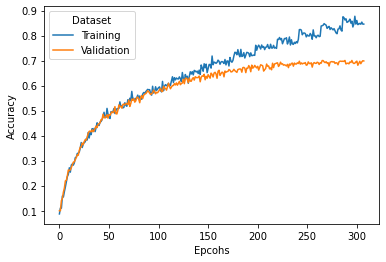

In [114]:
plt.plot(m2_train_accuray, label = "Training")
plt.plot(m2_val_accuracy, label = "Validation")
plt.legend(title="Dataset")
plt.ylabel("Accuracy")
plt.xlabel("Epcohs")

### Testind dataset accuracy of Model-2

In [60]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 70 %


## Model 3
We increase the complexity of the network by adding another VGG block to it, so that the network has 3 VGG blocks in it.

In [61]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet3(nn.Module):
    def __init__(self):
        super().__init__()
        
        # block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # block 2
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding = 1)
        
        # block 3
        self.conv5 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding = 1)
        
        # 
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # block 1
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        # block 2
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        
        # block 3
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        
        # fully connected layers
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
    
        return x

net3 = ConvNet3()

In [62]:
# checking forward pass
net3(torch.rand(1,3,32,32)).shape

torch.Size([1, 10])

## Training Model 3

In [63]:
import torch.optim as optim

# optimizer for model 3
optimizer3 = optim.SGD(net3.parameters(), 
                      lr=0.01) # smaller learning rate did not work properly

# loss function for model 3
loss_fn = nn.CrossEntropyLoss()

In [64]:
# lists to track training progress for Model-3
m3_batch = []
m3_train_loss = []
m3_train_accuray = []
m3_val_loss = []
m3_val_accuracy = []

In [79]:
# defining the training epochs 10
N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    
    # loss calculate for an epoch
    running_loss = 0.0
    correct = 0
    seen = 0
    
    for i, data in enumerate(train_loader, 0):
        # getting the batch for training
        inputs, labels = data

        # zero the accumulated parameter gradients
        optimizer3.zero_grad()

        # forward pass
        outputs = net3(inputs)
        
        # calculating the outputs
        _, predicted = torch.max(outputs.data, 1)
        
        # calculating the loss for batch
        loss = loss_fn(outputs, labels)
        
        # calculating the gradients by backward pass
        loss.backward()
        
        # updating the prameters based on gradient
        optimizer3.step()

        # print statistics
        running_loss += loss.item()
        
        seen += len(predicted)
        correct += sum(predicted == labels)
        
        if i % 500 == 499:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}, accuracy: {correct/seen:0.3f}')
            
            #storing the loss and accuracy
            m3_batch += [(epoch+1) * (i+1)]
            m3_train_loss += [running_loss / 2000]
            m3_train_accuray +=  [correct / seen]
            
            running_loss = 0.0
            correct = seen = 0
            
            # validation set loss and accuracy
            with torch.no_grad():
                val_loss = 0
                val_correct = 0
                val_seen = 0
                for inputs, labels in validation_loader:
                    outputs = net3(inputs)

                    # calculating the outputs
                    _, predicted = torch.max(outputs.data, 1)

                    # calculating the loss for validation batch
                    val_loss += loss_fn(outputs, labels)
                    
                    # calculating accuracy for the validation batch
                    val_correct += sum(predicted == labels)
                    val_seen += len(labels)
                    
                m3_val_loss += [val_loss]
                m3_val_accuracy += [val_correct/val_seen]
                print(f'[{epoch + 1}, {i + 1:5d}] val loss: {val_loss/2000:0.3f}, accuracy: {val_correct/val_seen:0.3f}')

print('Finished Training')

[1,   500] loss: 0.045, accuracy: 0.938
[1,   500] val loss: 0.646, accuracy: 0.752
[1,  1000] loss: 0.053, accuracy: 0.924
[1,  1000] val loss: 0.617, accuracy: 0.754
[1,  1500] loss: 0.054, accuracy: 0.926
[1,  1500] val loss: 0.619, accuracy: 0.761
[1,  2000] loss: 0.070, accuracy: 0.904
[1,  2000] val loss: 0.671, accuracy: 0.745
[1,  2500] loss: 0.059, accuracy: 0.920
[1,  2500] val loss: 0.640, accuracy: 0.742
[1,  3000] loss: 0.063, accuracy: 0.914
[1,  3000] val loss: 0.696, accuracy: 0.728
[1,  3500] loss: 0.065, accuracy: 0.911
[1,  3500] val loss: 0.594, accuracy: 0.757
[1,  4000] loss: 0.058, accuracy: 0.919
[1,  4000] val loss: 0.623, accuracy: 0.759
[1,  4500] loss: 0.063, accuracy: 0.914
[1,  4500] val loss: 0.638, accuracy: 0.757
[1,  5000] loss: 0.078, accuracy: 0.893
[1,  5000] val loss: 0.622, accuracy: 0.742
[1,  5500] loss: 0.075, accuracy: 0.900
[1,  5500] val loss: 0.601, accuracy: 0.749
[1,  6000] loss: 0.078, accuracy: 0.890
[1,  6000] val loss: 0.579, accuracy

Text(0.5, 0, 'Epcohs')

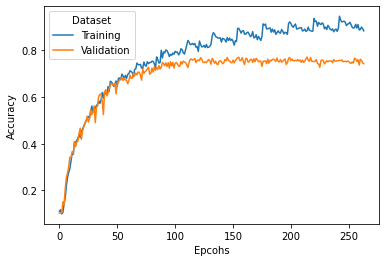

In [116]:
plt.plot(m3_train_accuray, label = "Training")
plt.plot(m3_val_accuracy, label = "Validation")
plt.legend(title="Dataset")
plt.ylabel("Accuracy")
plt.xlabel("Epcohs")

### Testing dataset accuracy of Model-3

In [76]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net3(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 76 %


## Final model

To prevent model from overfitting, we use dropout regularization in Model-3

In [94]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet4(nn.Module):
    def __init__(self):
        super().__init__()
        
        # block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # block 2
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding = 1)
        
        # block 3
        self.conv5 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding = 1)
        
        # fully connected layers
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # regularization layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # block 1
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        
        # block 2
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        
        # block 3
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.dropout(x)
        
        # fully connected layers
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

net4 = ConvNet4()

In [95]:
# checking forward pass
net4(torch.rand(1,3,32,32)).shape

torch.Size([1, 10])

### Training regularized model

In [96]:
import torch.optim as optim

# optimizer for regularized model
optimizer4 = optim.SGD(net4.parameters(), 
                      lr=0.01) # we can use larger learning rate due to regularization

# loss function for regularized model
loss_fn = nn.CrossEntropyLoss()

In [97]:
# lists to track training progress for regularized model
m4_batch = []
m4_train_loss = []
m4_train_accuray = []
m4_val_loss = []
m4_val_accuracy = []

In [109]:
# defining the training epochs 10
N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    
    # loss calculate for an epoch
    running_loss = 0.0
    correct = 0
    seen = 0
    
    for i, data in enumerate(train_loader, 0):
        # getting the batch for training
        inputs, labels = data

        # zero the accumulated parameter gradients
        optimizer4.zero_grad()

        # forward pass
        outputs = net4(inputs)
        
        # calculating the outputs
        _, predicted = torch.max(outputs.data, 1)
        
        # calculating the loss for batch
        loss = loss_fn(outputs, labels)
        
        # calculating the gradients by backward pass
        loss.backward()
        
        # updating the prameters based on gradient
        optimizer4.step()

        # print statistics
        running_loss += loss.item()
        
        seen += len(predicted)
        correct += sum(predicted == labels)
        
        if i % 500 == 499:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}, accuracy: {correct/seen:0.3f}')
            
            #storing the loss and accuracy
            m4_batch += [(epoch+1) * (i+1)]
            m4_train_loss += [running_loss / 2000]
            m4_train_accuray +=  [correct / seen]
            
            running_loss = 0.0
            correct = seen = 0
            
            # validation set loss and accuracy
            with torch.no_grad():
                val_loss = 0
                val_correct = 0
                val_seen = 0
                for inputs, labels in validation_loader:
                    outputs = net4(inputs)

                    # calculating the outputs
                    _, predicted = torch.max(outputs.data, 1)

                    # calculating the loss for validation batch
                    val_loss += loss_fn(outputs, labels)
                    
                    # calculating accuracy for the validation batch
                    val_correct += sum(predicted == labels)
                    val_seen += len(labels)
                    
                m4_val_loss += [val_loss]
                m4_val_accuracy += [val_correct/val_seen]
                print(f'[{epoch + 1}, {i + 1:5d}] val loss: {val_loss/2000:0.3f}, accuracy: {val_correct/val_seen:0.3f}')

print('Finished Training')

[1,   500] loss: 0.114, accuracy: 0.837
[1,   500] val loss: 0.449, accuracy: 0.761
[1,  1000] loss: 0.103, accuracy: 0.854
[1,  1000] val loss: 0.471, accuracy: 0.760
[1,  1500] loss: 0.105, accuracy: 0.853
[1,  1500] val loss: 0.470, accuracy: 0.760
[1,  2000] loss: 0.113, accuracy: 0.842
[1,  2000] val loss: 0.470, accuracy: 0.751
[1,  2500] loss: 0.103, accuracy: 0.845
[1,  2500] val loss: 0.486, accuracy: 0.754
[1,  3000] loss: 0.111, accuracy: 0.849
[1,  3000] val loss: 0.541, accuracy: 0.736
[1,  3500] loss: 0.108, accuracy: 0.850
[1,  3500] val loss: 0.484, accuracy: 0.756
[1,  4000] loss: 0.110, accuracy: 0.846
[1,  4000] val loss: 0.468, accuracy: 0.758
[1,  4500] loss: 0.110, accuracy: 0.849
[1,  4500] val loss: 0.487, accuracy: 0.747
[1,  5000] loss: 0.121, accuracy: 0.826
[1,  5000] val loss: 0.492, accuracy: 0.757
[1,  5500] loss: 0.121, accuracy: 0.835
[1,  5500] val loss: 0.472, accuracy: 0.759
[1,  6000] loss: 0.128, accuracy: 0.820
[1,  6000] val loss: 0.473, accuracy

Text(0.5, 0, 'Epcohs')

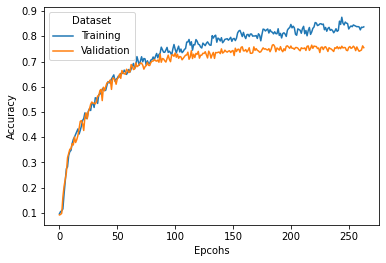

In [117]:
plt.plot(m4_train_accuray, label = "Training")
plt.plot(m4_val_accuracy, label = "Validation")
plt.legend(title="Dataset")
plt.ylabel("Accuracy")
plt.xlabel("Epcohs")

### Testing dataset accuracy of regularized model

In [111]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net4(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 75 %


## Comparing validation loss of models

We observe that with increasing number of layers in the model the testing accuracy of model increases.

Text(0.5, 0, 'Epcohs')

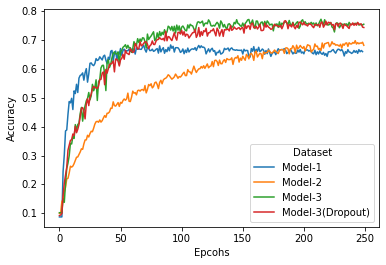

In [171]:
plt.plot(m1_val_accuracy[20:269], label = "Model-1")
plt.plot(m2_val_accuracy[:250], label = "Model-2")
plt.plot(m3_val_accuracy[:250], label = "Model-3")
plt.plot(m4_val_accuracy[:250], label = "Model-3(Dropout)")
plt.legend(title="Dataset")
plt.ylabel("Accuracy")
plt.xlabel("Epcohs")

## Testing dataset accuracy

Similar trend is observed for testing accuracy of the dataset

|Model|Testing accuracy|
|-|-|
|Model 1| 65%|
|Model-2| 70%|
|Model-3| 76%|
|Model-3 with Dropout| 75%|